# TITLE: A Stochastic Climate Model

### Background

In 1976, Claude Frankignoul and Klaus Hasselman published the second of a series of papers introducing a stochastic model for climate variability. Their 1976 paper linked short-term "stochastic" atmospheric perturbations (weather) to the long-term fluctuations in global mean sea surface temperature (climate). The work illustrated that the coupled climate system acts as a white-noise integrator: the random fluctuations of the atmosphere on weather timescales, which can be thought of as white noise, induce slower, "red" fluctuations in the SSTs on climate timescales as the ocean accrues "memory" of each individual atmospheric perturbation. 

Their model has since been widely used (REFERENCES) and is today a critical underpinning of attempts to understand [ECS], [INSERT THING HERE], [INSERT OTHER THING HERE], and [INSERT FINAL THING HERE]. 

The FH76 model of SST anomaly evolution demonstrates the function of the climate system as a white-noise integrator by forcing a simple model of SST change per time step with atmospheric white noise. 

The atmospheric white noise takes the form of total heat flux (from atmosphere into ocean), parameterized in terms of the wind. 

The total heat moving through the air-sea interface is $H_S + H_L$.

$H_S = C_{S}\rho_aC_{p}^{a}\Delta T\textbf{U}$ 

$H_L = C_{L}\rho_aC_{p}^{a}\Delta T\textbf{U}$

$B = \frac{C_{L}}{C_{S}}$

$H_S + H_L = C_S(1 + B)\rho_aC_{p}^{a}\Delta T\textbf{U}$

In [1]:
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

#set seaborn plotting aesthetics as default
sns.set_theme(context='notebook', style='darkgrid')

### The Model

In [16]:
def fh76(U, V, t, h=25, toy=True):

    # Heat flux parameterizations
    C_h = 1e-3      # bulk transfer coefficient, sensible heat flux
    Bow = 3         # ratio of latent to sensible heat flux
    p_a = 1.25e-3   # density of air (g/cm3)
    p_w = 1         # density of water (g/cm3)
    Cap = 0.24      # specific heat of air (cal/g/degC)
    Cwp = 0.96      # specific heat of water (cal/g/degC)
    K = 0.25      # const. of proportionality (temp to NW wind)

    # Model operator
    if toy is True:
        T = []
        heat_flux = []
        change = []
        for i in range(0,len(U)):
            heat_flux.append(C_h * (1+Bow) * (p_a*Cap*K*V[i]*np.abs(U[i]))/(p_w*Cwp))
            del_T = heat_flux[i]/h * t
            if i == 0:
                T.append(del_T)
            else:
                T.append(T[i-1] + del_T)
            change.append(del_T)

    else:
        U_anom = U.groupby('time.dayofyear') - U.groupby('time.dayofyear').mean(dim='time')
        V_anom = V.groupby('time.dayofyear') - V.groupby('time.dayofyear').mean(dim='time')
        heat_flux = C_h * (1+Bow) * (p_a*Cap*K*V_anom*np.abs(U_anom))
        change = heat_flux/(p_w*Cwp*h) * t
        T = change.cumsum(dim='time')

    # Plotting the results
    fig, axes = plt.subplots(3, 1, figsize=(8,5))

    if toy is True:
        #create boxplot in each subplot
        sns.lineplot(data=heat_flux, ax=axes[0])
        sns.lineplot(data=change, ax=axes[1])
        sns.lineplot(data=T, ax=axes[2])
    else:
         #create boxplot in each subplot
        sns.lineplot(data=heat_flux.mean(dim='space'), ax=axes[0])
        sns.lineplot(data=change.mean(dim='space'), ax=axes[1])
        sns.lineplot(data=T.mean(dim='space'), ax=axes[2])

    axes[0].set_title('Forcing', fontweight='bold')
    axes[1].set_title('Change/$\Delta$t', fontweight='bold')
    axes[2].set_title('Temperature', fontweight='bold')

    plt.tight_layout()

    return T, heat_flux, change

### Three Experiments

#### "It's Basically a Coin Flip"

In [3]:
U = 5 * np.random.randn(4*365*10)
V = 1 * np.random.randn(4*365*10)

h = 25        # mixed layer depth (m)
t = 60*60*6   # timestep (every six hours)

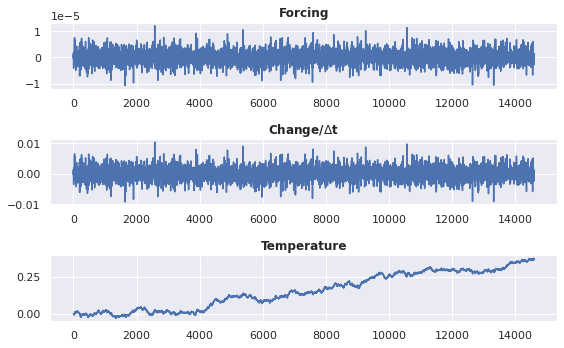

In [4]:
T, forcing, change = fh76(U, V, t)

#### Modelled Winds: CESM2-LE, 1850-1860

In [5]:
Ufile = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/hour_6/U/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h5.U.1850010100-1859123100.nc'
Vfile = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/hour_6/V/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h5.V.1850010100-1859123100.nc'
U_data = xr.open_dataset(Ufile)
V_data = xr.open_dataset(Vfile)

U = U_data.U[:,-1,:,:].stack(space=('lat','lon'))
V = V_data.V[:,-1,:,:].stack(space=('lat','lon'))

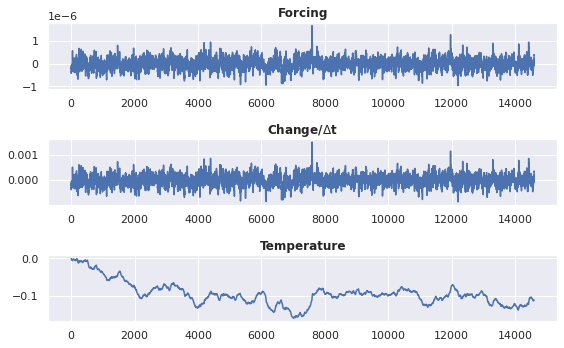

In [17]:
T_real, forcing, change = fh76(U, V, t, toy=False)

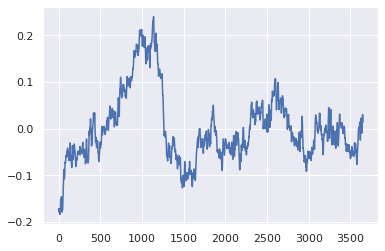

In [22]:
# compare to mean SST anomaly evolution from the same ensemble member
file = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ocn/proc/tseries/day_1/SST/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.pop.h.nday1.SST.18500101-18600101.nc'
ds = xr.open_dataset(file)
plt.plot((ds.SST.stack(space=('nlat','nlon')).groupby('time.dayofyear') - ds.SST.stack(space=('nlat','nlon')).groupby('time.dayofyear').mean(dim='time')).mean(dim='space'))

#### Application to Sea Ice

If we want to think about how "white" atmospheric forcing might induce low-frequency variability in sea ice, we can adapt the model in the following way: 


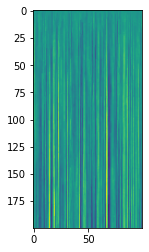

In [48]:
plt.imshow(T)

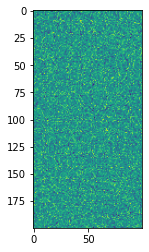

In [49]:
plt.imshow(U)